In [1]:
#record path to each IP prefix of each peer
#record prefix table
#record as table
import pybgpstream
from tqdm.notebook import tqdm, trange
from datetime import timedelta, datetime
import json
import networkx as nx
from itertools import groupby
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

## 2022-03-28 12:23:56 UTC 104.244.42.0/24 in AS13414 hijacked by AS8342

In [26]:
stream = pybgpstream.BGPStream(
    # Consider this time interval:
    # Sat, 01 Aug 2015 7:50:00 GMT -  08:10:00 GMT
    from_time="2022-03-28 11:59:59", until_time="2022-03-28 12:05:00",
    collectors=["route-views5"],
    record_type="ribs"
)

In [27]:
#record as path of each prefix governed by AS13414
prefix_13414_as_path = defaultdict(dict)
start_time = time.time()
i = 0
for rec in tqdm(stream.records()):
    for ele in rec:
        # Get the peer ASn
        i += 1
        peer = str(ele.peer_asn)
        hops = [k for k, g in groupby(ele.fields['as-path'].split(" "))]
        if str(ele.type) == "R":
            if 'as-path' and "prefix" in ele.fields and hops[-1] == "13414":
                IP = ele.fields["prefix"]
                prefix_13414_as_path[IP][peer] = hops
print(i)
print("--- %s seconds ---" % (time.time() - start_time))

0it [00:00, ?it/s]

9614018
--- 88.22310757637024 seconds ---


In [28]:
with open("prefixASpath_rv5_2022_03_28_120000_as13414.json", "w") as f:
    json.dump(prefix_13414_as_path, f)

In [90]:
prefix_13414_as_path.keys()

dict_keys(['64.63.0.0/18', '64.63.32.0/24', '64.63.33.0/24', '69.195.160.0/24', '69.195.162.0/24', '69.195.163.0/24', '69.195.164.0/24', '69.195.165.0/24', '69.195.166.0/24', '69.195.168.0/24', '69.195.169.0/24', '69.195.171.0/24', '69.195.172.0/24', '69.195.174.0/24', '69.195.175.0/24', '69.195.176.0/24', '69.195.177.0/24', '69.195.178.0/24', '69.195.179.0/24', '69.195.180.0/24', '69.195.181.0/24', '69.195.182.0/24', '69.195.183.0/24', '69.195.184.0/24', '69.195.185.0/24', '69.195.186.0/24', '69.195.187.0/24', '69.195.188.0/24', '69.195.189.0/24', '69.195.190.0/24', '69.195.191.0/24', '103.252.112.0/23', '103.252.114.0/23', '104.244.40.0/24', '104.244.41.0/24', '104.244.42.0/24', '104.244.44.0/24', '104.244.45.0/24', '104.244.46.0/24', '104.244.47.0/24', '185.45.5.0/24', '185.45.6.0/23', '188.64.224.0/21', '192.44.69.0/24', '192.133.76.0/22', '192.133.76.0/23', '199.16.156.0/22', '199.16.156.0/23', '199.59.148.0/22', '199.96.56.0/23', '199.96.56.0/24', '199.96.57.0/24', '199.96.58.0/2

In [91]:
prefix_13414_as_path['104.244.42.0/24'].keys()

dict_keys(['2914', '293', '3257', '6079', '6830', '17350', '25885', '398465', '6939', '11039', '19151', '16552', '199524', '8220', '41095', '40934', '37468'])

In [29]:
#Read update message until 12:22:00
stream1 = pybgpstream.BGPStream(
    from_time="2022-03-28 12:00:00", until_time="2022-03-28 12:05:00",
    collectors=["route-views5"],
    record_type="updates"
)

In [30]:
prefix_13414_as_path_122200 = copy.deepcopy(prefix_13414_as_path)
i = 0
start_time = time.time()
types = {"A", "W"}
target_IP = set(prefix_13414_as_path.keys())
for rec in stream1.records():
    for elem in rec:
        i += 1
        if (str(elem.type) in types) and "prefix" in elem.fields:
            IP = str(elem.fields["prefix"])
            if IP in target_IP:
                if str(elem.type) == "A" and "as-path" in elem.fields:
                    peer = str(elem.peer_asn)
                    hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
                    prefix_13414_as_path_122200[IP][peer] = hops
                if str(elem.type) == "W":
                    peer = str(elem.peer_asn)
                    prefix_13414_as_path_122200[IP][peer] = []
print(i)
print("--- %s seconds ---" % (time.time() - start_time))

267730
--- 4.826679706573486 seconds ---


In [31]:
with open("prefixASpath_rv5_2022_03_20_122200_as13414ip.json", "w") as f:
    json.dump(prefix_13414_as_path_122200, f)

In [32]:
#read update message until 12:30:01
stream2 = pybgpstream.BGPStream(
    from_time="2022-03-28 12:05:00", until_time="2022-03-28 12:45:00",
    collectors=["route-views5"],
    record_type="updates"
)

In [33]:
prefix_13414_as_path_123000 = copy.deepcopy(prefix_13414_as_path_122200)
i = 0
j = 0
start_time = time.time()
types = {"A", "W"}
target_IP = set(prefix_13414_as_path.keys())
for rec in tqdm(stream2.records()):
    for elem in rec:
        i += 1
        if (str(elem.type) in types) and "prefix" in elem.fields:
            IP = str(elem.fields["prefix"])
            if IP in target_IP:
                j += 1
                
                if str(elem.type) == "A" and ("as-path" in elem.fields):
                    
                    peer = str(elem.peer_asn)
                    hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
                    prefix_13414_as_path_123000[IP][peer] = hops
                if str(elem.type) == "W":
                    peer = str(elem.peer_asn)
                    prefix_13414_as_path_123000[IP][peer] = []
print(i, j)
print("--- %s seconds ---" % (time.time() - start_time))

0it [00:00, ?it/s]

658856 59
--- 8.931632041931152 seconds ---


In [34]:
with open("prefixASpath_rv5_2022_03_20_124000_as13414ip.json", "w") as f:
    json.dump(prefix_13414_as_path_123000, f)

In [35]:
## Create graph at each timestamp
## plot all paths from peer to IP address '104.244.42.0/24' and connect IP with the last on hop
as_graph_rib = nx.Graph()
for peer in prefix_13414_as_path['104.244.42.0/24'].keys():
    as_path = prefix_13414_as_path['104.244.42.0/24'][peer]
    for i in range(0, len(as_path)-1):
        as_graph_rib.add_edge(as_path[i], as_path[i+1])
    if len(as_path) > 0:
        as_graph_rib.add_edge(as_path[-1], '104.244.42.0/24')

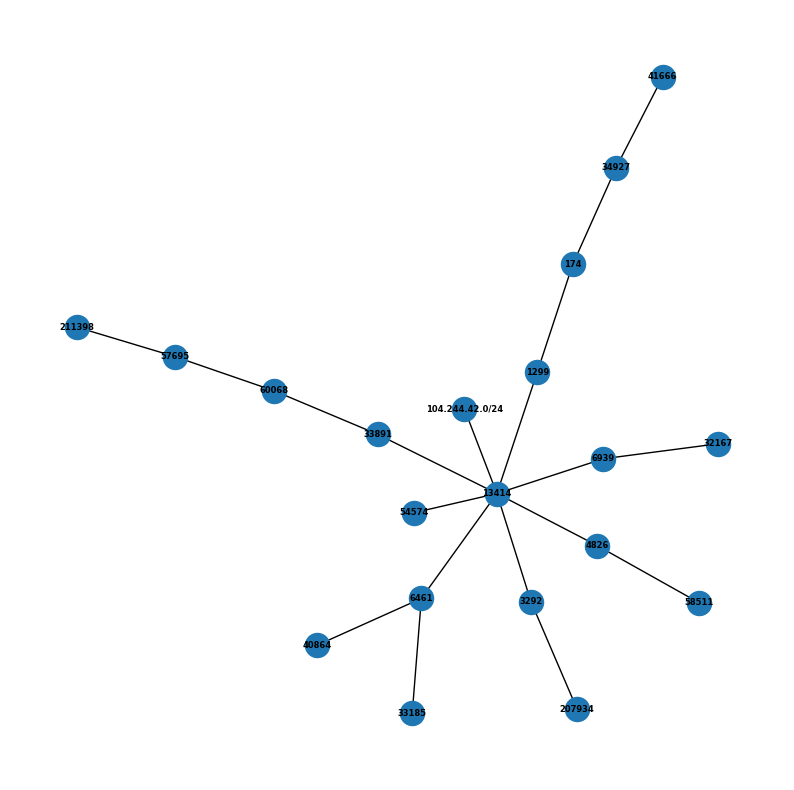

In [36]:
#pos = hierarchy_pos(as_graph_rib, '104.244.42.0/24')
pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_rib, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_rib.png")

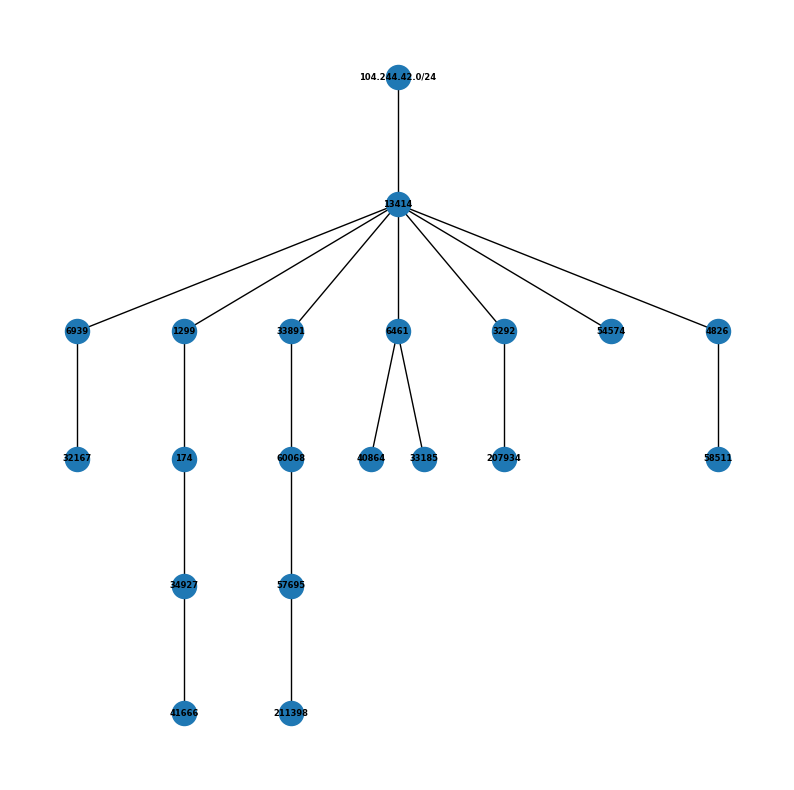

In [37]:
pos = hierarchy_pos(as_graph_rib, '104.244.42.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_rib, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_rib_tree.png")

In [38]:
##Graph before incident
as_graph_before = nx.Graph()
for peer in prefix_13414_as_path_122200['104.244.42.0/24'].keys():
    as_path = prefix_13414_as_path_122200['104.244.42.0/24'][peer]
    for i in range(0, len(as_path)-1):
        as_graph_before.add_edge(as_path[i], as_path[i+1])
    if len(as_path) > 0:
        as_graph_before.add_edge(as_path[-1], '104.244.42.0/24')

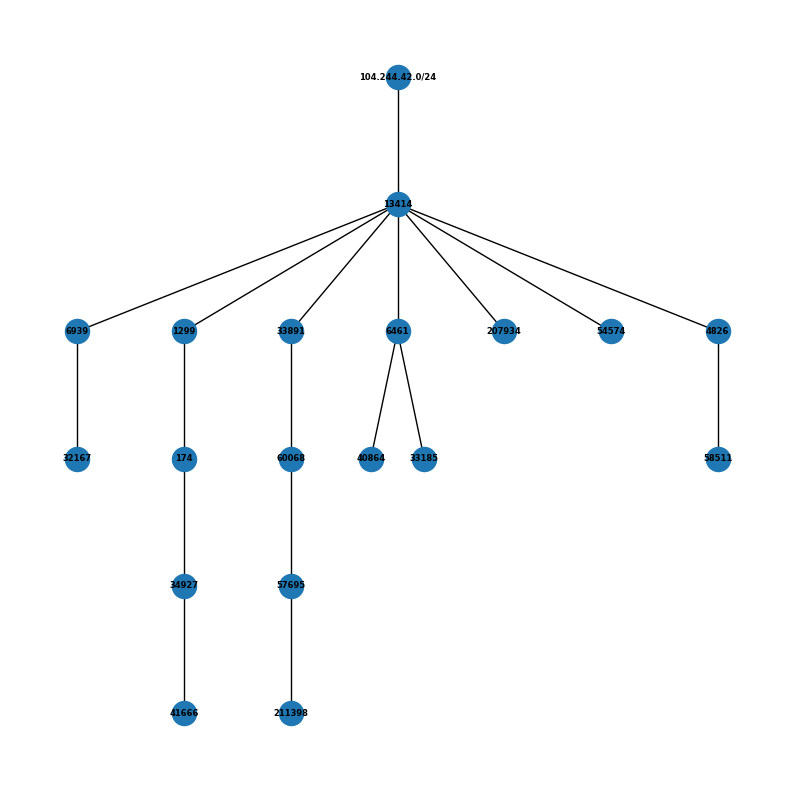

In [39]:
pos = hierarchy_pos(as_graph_before, '104.244.42.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_before, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_before_tree.png")

In [40]:
##Graph before incident
as_graph_after = nx.Graph()
for peer in prefix_13414_as_path_123000['104.244.42.0/24'].keys():
    as_path = prefix_13414_as_path_123000['104.244.42.0/24'][peer]
    for i in range(0, len(as_path)-1):
        as_graph_after.add_edge(as_path[i], as_path[i+1])
    if len(as_path) > 0:
        as_graph_after.add_edge(as_path[-1], '104.244.42.0/24')

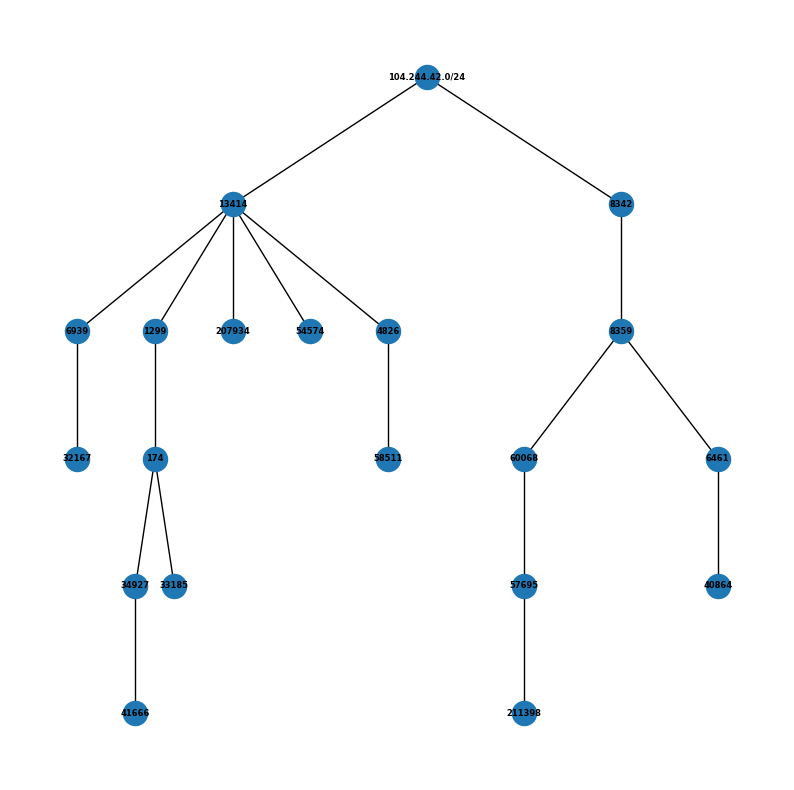

In [41]:
pos = hierarchy_pos(as_graph_after, '104.244.42.0/24')
#pos = nx.kamada_kawai_layout(as_graph_rib)
ax = plt.subplots(1, figsize=(10, 10))
nx.draw(as_graph_after, pos=pos, with_labels=True, font_weight='bold', font_size=6)
plt.savefig("13414_rv5_ip24_after_tree.png")

In [45]:
prefix_13414_as_path_123000['104.244.42.0/24']

{'32167': ['32167', '6939', '13414'],
 '41666': ['41666', '34927', '174', '1299', '13414'],
 '211398': ['211398', '57695', '60068', '8359', '8342'],
 '40864': ['40864', '6461', '8359', '8342'],
 '207934': ['207934', '13414'],
 '33185': ['33185', '174', '1299', '13414'],
 '54574': ['54574', '13414'],
 '58511': ['58511', '4826', '13414']}

In [46]:
stream2 = pybgpstream.BGPStream(
    from_time="2022-03-28 12:00:00 UTC", until_time="2022-03-28 13:00:00 UTC",
    collectors=["route-views2"],
    record_type="updates"
)

In [47]:
target_IP_messages = []
i = 0
types = {"A", "W"}
for rec in tqdm(stream2.records()):
    for elem in rec:
        i += 1
        if (str(elem.type) in types) and "prefix" in elem.fields:
            IP = str(elem.fields["prefix"])
            if IP == '104.244.42.0/24':
                print(elem)
                target_IP_messages.append(elem)

0it [00:00, ?it/s]

update|A|1648469184.467364|routeviews|route-views2|None|None|13030|213.144.128.203|104.244.42.0/24|213.144.128.203|13030 8359 8342|13030:1 13030:50000 13030:8222 13030:51202 13030:3|None|None
update|A|1648469190.262315|routeviews|route-views2|None|None|1403|198.58.198.252|104.244.42.0/24|198.58.198.252|1403 1299 13414 13414|1299:35000|None|None
update|A|1648469199.504047|routeviews|route-views2|None|None|22652|45.61.0.85|104.244.42.0/24|45.61.0.85|22652 8359 8342|8342:666 22652:51101 0:20940 8359:55277 22652:51005 8359:5500 63034:63034 22652:51359 22652:50003|None|None
update|A|1648469211.353582|routeviews|route-views2|None|None|3741|168.209.255.56|104.244.42.0/24|168.209.255.56|3741 8359 8342||None|None
update|A|1648471838.632990|routeviews|route-views2|None|None|13030|213.144.128.203|104.244.42.0/24|213.144.128.203|13030 13414 13414|13030:1 13030:50000 13030:4006 13030:51702 13030:7221 13030:1008|None|None
update|A|1648471842.980612|routeviews|route-views2|None|None|22652|45.61.0.85|

In [25]:
datetime.fromtimestamp(1648469213.677691)

datetime.datetime(2022, 3, 28, 12, 6, 53, 677691)